Connection to mysql+mysqldb://localhost:3306/HVAC successfull
2017-01-01 00:00:00 2017-01-01 00:10:00 [<class 'hvacDBMapping.ThermafuserReading'>]


airflowFeedback  occupiedCoolingSetpoint  \
timestamp  thermafuserId                                             
2017-01-01 1                         46.0                     76.0   
           2                         21.0                     76.0   
           3                         21.0                     76.0   
           4                         53.0                     76.0   
           5                         63.0                     76.0   

                          occupiedHeatingSetpoint  roomOccupied  supplyAir  \
timestamp  thermafuserId                                                     
2017-01-01 1                                 70.0          True       77.5   
           2                                 70.0          True       90.0   
           3                                 70.0          True       71.8   
           4                                 70.0          True       73.4   
           5                                 70.0          True       85.7   

                          zoneTemperature  
timestamp  thermafuserId                   
2017-01-01 1                         67.7  
           2                         71.1  
           3                         64.4  
           4                         63.5  
           5                         66.3

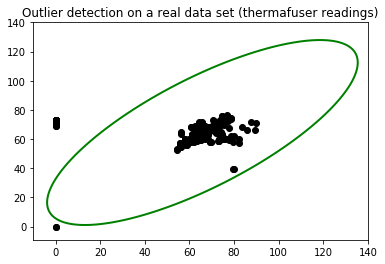

In [14]:
import anomaly_detection
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager
from datetime import datetime
from IPython.display import display, HTML
from numpy import nan
from sklearn.covariance import EllipticEnvelope

desiredComponents = ['Thermafuser']

startDateTime = datetime(2017, 1, 1, hour=0, minute=0, second=0, microsecond=0)
endDateTime = datetime(2017, 1, 1, hour=0, minute=10, second=0, microsecond=0)
    
dataFrames = anomaly_detection.loadData(startDateTime, endDateTime, desiredComponents)
arrays = anomaly_detection.getDataForGaussianAnalysis(dataFrames)

for key in dataFrames:
    display(dataFrames[key].head())

plt.figure(1)
for key in arrays:
    #print(key, arrays[key].shape)
    #print(arrays[key])
    X = arrays[key]
    gaussianClassifier = EllipticEnvelope(contamination=0.1)
    gaussianClassifier.fit(X)
    
    xx1, yy1 = np.meshgrid(np.linspace(-10, 140, 500), np.linspace(0, 140, 500))
    z = gaussianClassifier.decision_function(np.c_[xx1.ravel(), yy1.ravel()])
    z = z.reshape(xx1.shape)
    plt.contour(xx1, yy1, z, levels=[0], linewidths=2, colors='g')
    
    plt.title("Outlier detection on a real data set (thermafuser readings)")
    plt.scatter(X[:, 0], X[:, 1], color='black')
    
plt.show()
    